In [1]:
import cv2
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
base_dir = "Images"

In [3]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Root directory contains all subdirectories (e.g., 'good', 'crack', etc.)
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate through subdirectories
        for subdir in os.listdir(root_dir):
            subdir_path = os.path.join(root_dir, subdir)
            if os.path.isdir(subdir_path):
                # If the subdirectory is 'good', label as 0 (non-anomalous), else label as 1
                label = 0 if subdir == 'good' else 1
                for image_name in os.listdir(subdir_path):
                    image_path = os.path.join(subdir_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [4]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 1 input channel (grayscale image)
            nn.ReLU(),
            nn.BatchNorm2d(16),  # Batch normalization after convolution
            nn.Dropout(0.25),    # Dropout layer to prevent overfitting
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Batch normalization after convolution
            nn.Dropout(0.25),    # Dropout layer
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # New deeper layer
            nn.ReLU(),
            nn.BatchNorm2d(64),  # Batch normalization after convolution
            nn.Dropout(0.25),    # Dropout layer
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Batch normalization after deconvolution
            nn.Dropout(0.25),    # Dropout layer
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),  # Batch normalization after deconvolution
            nn.Dropout(0.25),    # Dropout layer
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # To normalize output to [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
# Prepare the data
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((512, 512)),  # Resize to a fixed size
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Light jitter
    transforms.ToTensor()
])

In [6]:
def calculate_reconstruction_errors(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    reconstruction_errors = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            reconstructed = model(images)

            # Compute the reconstruction error (e.g., Mean Squared Error)
            error = (images - reconstructed).pow(2).mean(dim=(1, 2, 3))  # Mean over height, width, channels
            reconstruction_errors.extend(error.cpu().numpy())  # Move to CPU and add to the list
    
    return reconstruction_errors

In [13]:
def train_autoencoder(autoencoder, dataloader, item, num_epochs, device, save_path="."):
    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)
    
    # Move the model to the specified device
    autoencoder.to(device)
    
    best_val_loss = float('inf')
    
    # Training loop
    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        
        for images, _ in dataloader:
            images = images.to(device)  # Move data to the same device as the model
            
            # Forward pass
            reconstructed = autoencoder(images)
            loss = criterion(reconstructed, images)  # Compare reconstructed and original images
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Print epoch summary
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.6f}")

        # Visualize some sample images and their reconstruction errors
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            autoencoder.eval()  # Set model to eval mode for visualization
            with torch.no_grad():
                sample_images, _ = next(iter(dataloader))  # Take a batch from the dataloader
                sample_images = sample_images.to(device)
                reconstructed = autoencoder(sample_images)

                # Plot original and reconstructed images
                fig, ax = plt.subplots(1, 2, figsize=(8, 6))
                ax[0].imshow(sample_images[0].cpu().squeeze(), cmap='gray')
                ax[0].set_title('Original Image')
                ax[0].axis('off')
                ax[1].imshow(reconstructed[0].cpu().squeeze(), cmap='gray')
                ax[1].set_title('Reconstructed Image')
                ax[1].axis('off')
                plt.show()

            # Calculate reconstruction errors for visualization after each epoch
            errors = calculate_reconstruction_errors(autoencoder, dataloader, device)
            
            # Plot histogram of reconstruction errors
            plt.figure(figsize=(6, 6))
            plt.hist(errors, bins=50, color='blue', alpha=0.7)
            plt.title(f'Distribution of Reconstruction Errors (Epoch {epoch + 1})')
            plt.xlabel('Reconstruction Error (MSE)')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

        # Save the model if validation loss has improved
        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            model_filename = f"{item}_autoencoder.pth"
            model_path = os.path.join(save_path, model_filename)
            torch.save(autoencoder.state_dict(), model_path)
            print(f"Model saved with test loss: {avg_loss:.4f}")
    
    return autoencoder, errors

In [19]:
def test_autoencoder(model, test_loader, device, threshold):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    anomalies = []
    false_positives = 0  # Counter for false positives
    total_good_images = 0  # Count of actual "good" images

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)  # These are the class labels (0 for "good", 1 for everything else)
            
            # Get the model's reconstruction of the images
            reconstructed = model(images)

            # Calculate the reconstruction error (difference between input and output)
            reconstruction_error = torch.mean((reconstructed - images) ** 2, dim=[1, 2, 3])

            # Identify anomalies based on reconstruction error exceeding the threshold
            predicted_anomalies = reconstruction_error > threshold

            # Track false positives: if the image is from the "good" class and predicted as anomalous
            for i, is_anomalous in enumerate(predicted_anomalies):
                image_label = labels[i].item()
                if image_label == 0:
                    total_good_images += 1
                    if is_anomalous.item():
                        anomalies.append((image_label, "Anomaly"))
                        false_positives += 1
                else:
                    anomalies.append((image_label, "Good"))

            # Flatten the tensors for comparison
            predicted_anomalies = predicted_anomalies.view(-1)  # Flatten the anomalies tensor
            labels = (labels != 0).view(-1)  # Flatten labels and treat "good" as non-anomalous

            # Count correct predictions (for anomaly detection, assuming "good" = non-anomalous, others = anomalous)
            correct += (predicted_anomalies == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    # false positive rate will be number of false positives divided by total number of "good" images in test dir
    false_positive_rate = false_positives / total_good_images if total_good_images > 0 else 0  # Avoid division by zero
    print(correct, total)
    print(false_positives, total_good_images)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")

Processing: capsule
Epoch [1/100], Loss: 0.130352


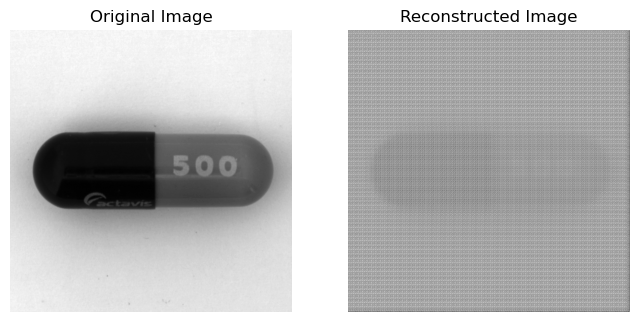

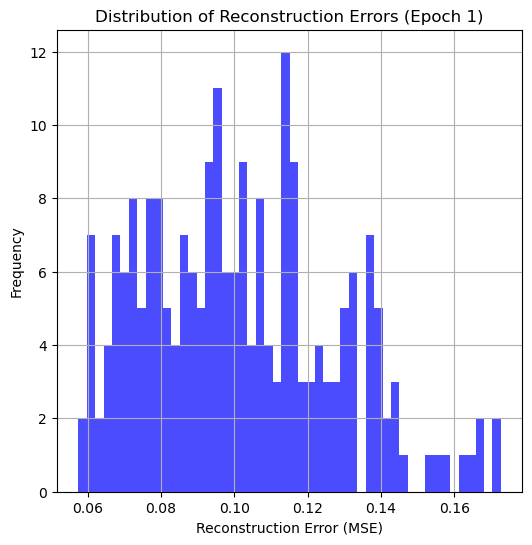

Model saved with test loss: 0.1304
Epoch [2/100], Loss: 0.074487
Model saved with test loss: 0.0745
Epoch [3/100], Loss: 0.048076
Model saved with test loss: 0.0481
Epoch [4/100], Loss: 0.038456
Model saved with test loss: 0.0385
Epoch [5/100], Loss: 0.030302
Model saved with test loss: 0.0303
Epoch [6/100], Loss: 0.023964
Model saved with test loss: 0.0240
Epoch [7/100], Loss: 0.022317
Model saved with test loss: 0.0223
Epoch [8/100], Loss: 0.017941
Model saved with test loss: 0.0179
Epoch [9/100], Loss: 0.016043
Model saved with test loss: 0.0160
Epoch [10/100], Loss: 0.014809
Model saved with test loss: 0.0148
Epoch [11/100], Loss: 0.012515


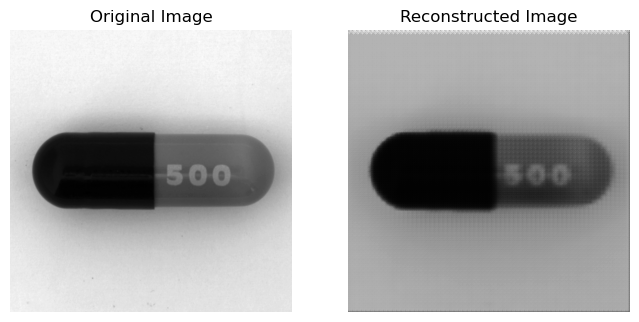

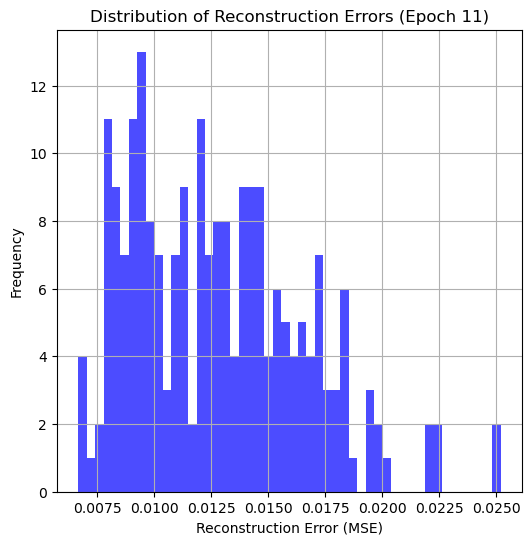

Model saved with test loss: 0.0125
Epoch [12/100], Loss: 0.011187
Model saved with test loss: 0.0112
Epoch [13/100], Loss: 0.010318
Model saved with test loss: 0.0103
Epoch [14/100], Loss: 0.009160
Model saved with test loss: 0.0092
Epoch [15/100], Loss: 0.008824
Model saved with test loss: 0.0088
Epoch [16/100], Loss: 0.008052
Model saved with test loss: 0.0081
Epoch [17/100], Loss: 0.007381
Model saved with test loss: 0.0074
Epoch [18/100], Loss: 0.007140
Model saved with test loss: 0.0071
Epoch [19/100], Loss: 0.006812
Model saved with test loss: 0.0068
Epoch [20/100], Loss: 0.006460
Model saved with test loss: 0.0065
Epoch [21/100], Loss: 0.006034


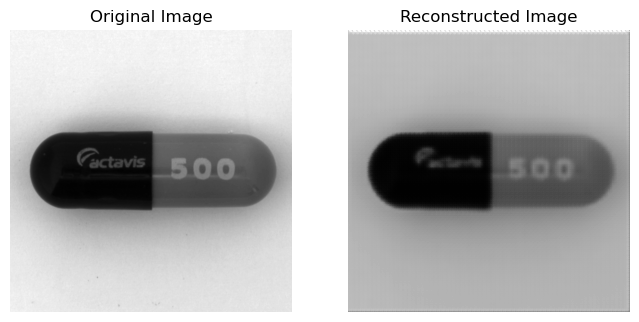

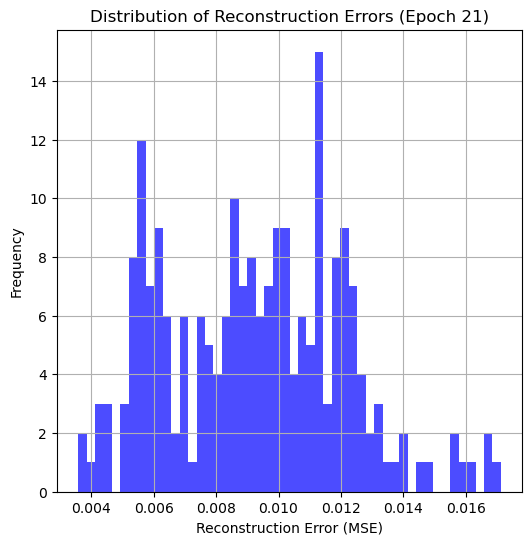

Model saved with test loss: 0.0060
Epoch [22/100], Loss: 0.005962
Model saved with test loss: 0.0060
Epoch [23/100], Loss: 0.005529
Model saved with test loss: 0.0055
Epoch [24/100], Loss: 0.005484
Model saved with test loss: 0.0055
Epoch [25/100], Loss: 0.005125
Model saved with test loss: 0.0051
Epoch [26/100], Loss: 0.004537
Model saved with test loss: 0.0045
Epoch [27/100], Loss: 0.004717
Epoch [28/100], Loss: 0.004365
Model saved with test loss: 0.0044
Epoch [29/100], Loss: 0.004344
Model saved with test loss: 0.0043
Epoch [30/100], Loss: 0.004050
Model saved with test loss: 0.0041
Epoch [31/100], Loss: 0.004063


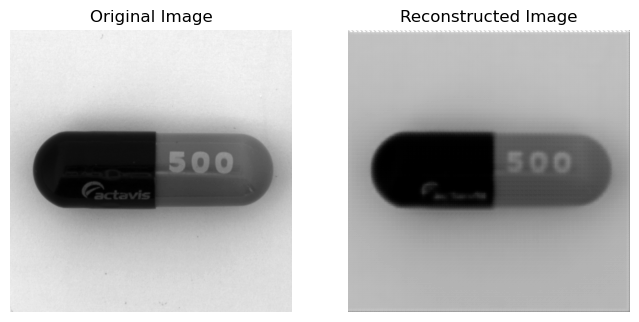

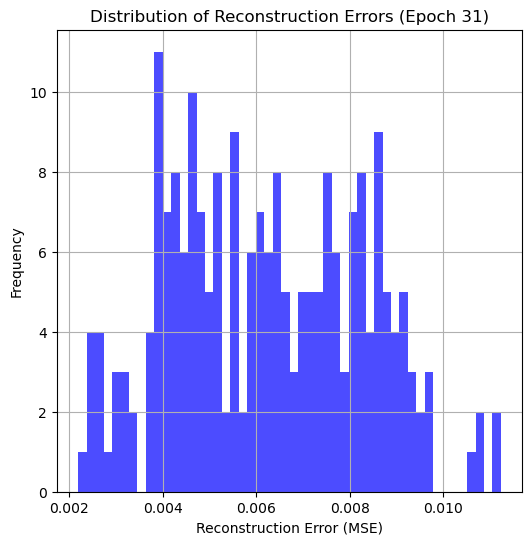

Epoch [32/100], Loss: 0.003690
Model saved with test loss: 0.0037
Epoch [33/100], Loss: 0.003479
Model saved with test loss: 0.0035
Epoch [34/100], Loss: 0.003720
Epoch [35/100], Loss: 0.003570
Epoch [36/100], Loss: 0.003189
Model saved with test loss: 0.0032
Epoch [37/100], Loss: 0.003324
Epoch [38/100], Loss: 0.003120
Model saved with test loss: 0.0031
Epoch [39/100], Loss: 0.002779
Model saved with test loss: 0.0028
Epoch [40/100], Loss: 0.003155
Epoch [41/100], Loss: 0.002845


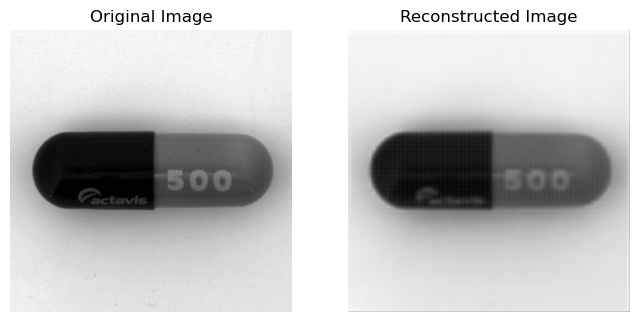

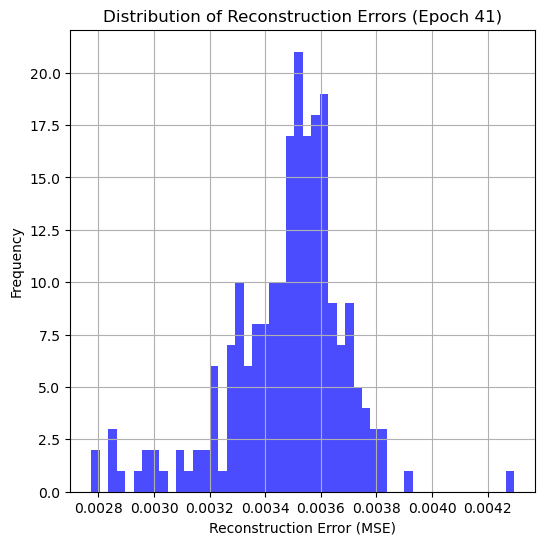

Epoch [42/100], Loss: 0.002935
Epoch [43/100], Loss: 0.002725
Model saved with test loss: 0.0027
Epoch [44/100], Loss: 0.002534
Model saved with test loss: 0.0025
Epoch [45/100], Loss: 0.002704
Epoch [46/100], Loss: 0.002686
Epoch [47/100], Loss: 0.002626
Epoch [48/100], Loss: 0.002635
Epoch [49/100], Loss: 0.002436
Model saved with test loss: 0.0024
Epoch [50/100], Loss: 0.002331
Model saved with test loss: 0.0023
Epoch [51/100], Loss: 0.002366


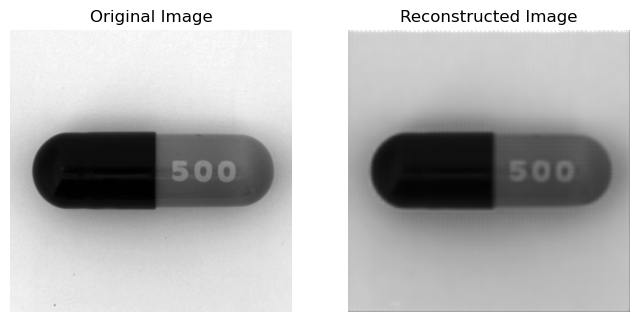

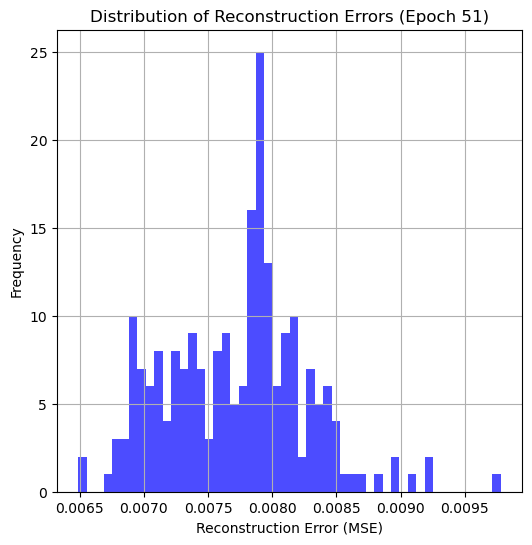

Epoch [52/100], Loss: 0.002726
Epoch [53/100], Loss: 0.002215
Model saved with test loss: 0.0022
Epoch [54/100], Loss: 0.002268
Epoch [55/100], Loss: 0.002487
Epoch [56/100], Loss: 0.002406
Epoch [57/100], Loss: 0.002335
Epoch [58/100], Loss: 0.002292
Epoch [59/100], Loss: 0.002195
Model saved with test loss: 0.0022
Epoch [60/100], Loss: 0.002185
Model saved with test loss: 0.0022
Epoch [61/100], Loss: 0.002175


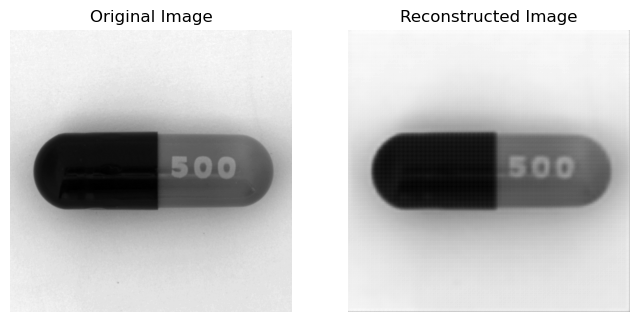

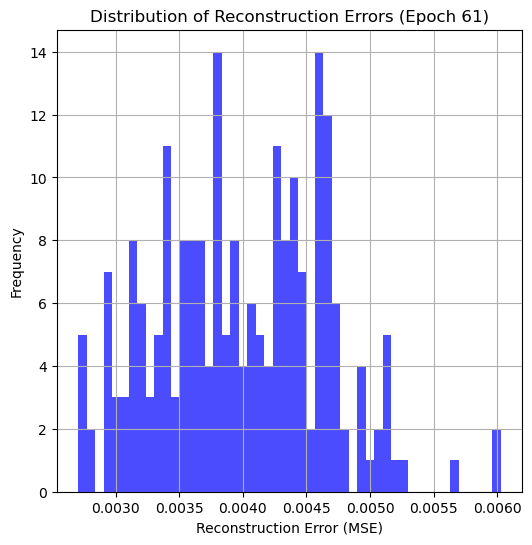

Model saved with test loss: 0.0022
Epoch [62/100], Loss: 0.001986
Model saved with test loss: 0.0020
Epoch [63/100], Loss: 0.002105
Epoch [64/100], Loss: 0.002219
Epoch [65/100], Loss: 0.002100
Epoch [66/100], Loss: 0.002395
Epoch [67/100], Loss: 0.002541
Epoch [68/100], Loss: 0.002149
Epoch [69/100], Loss: 0.002089
Epoch [70/100], Loss: 0.002143
Epoch [71/100], Loss: 0.002119


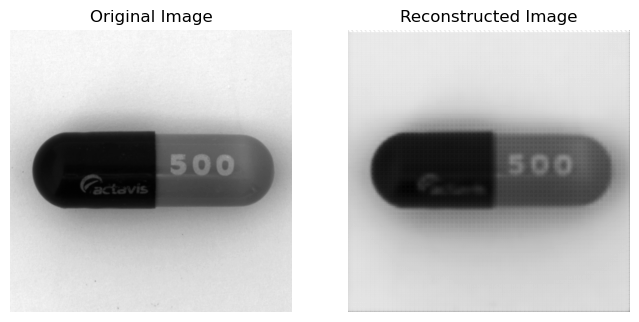

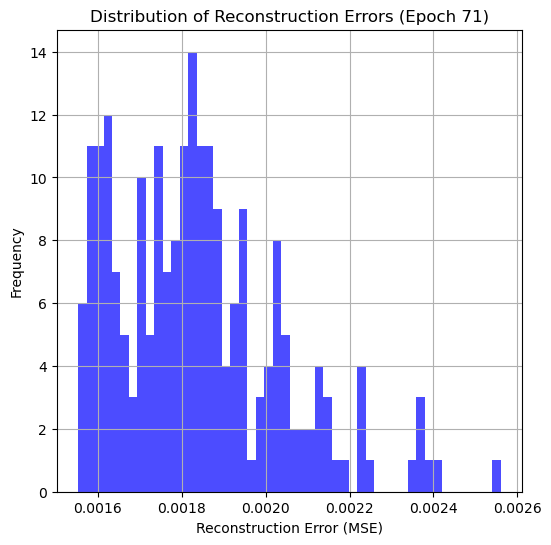

Epoch [72/100], Loss: 0.002202
Epoch [73/100], Loss: 0.002196
Epoch [74/100], Loss: 0.002033
Epoch [75/100], Loss: 0.001889
Model saved with test loss: 0.0019
Epoch [76/100], Loss: 0.001851
Model saved with test loss: 0.0019
Epoch [77/100], Loss: 0.001971
Epoch [78/100], Loss: 0.001808
Model saved with test loss: 0.0018
Epoch [79/100], Loss: 0.001938
Epoch [80/100], Loss: 0.002043
Epoch [81/100], Loss: 0.002031


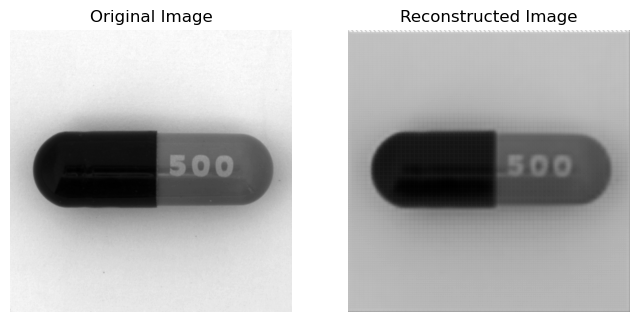

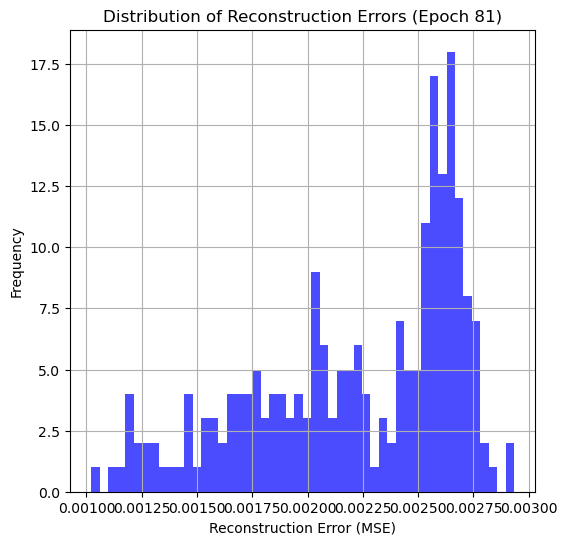

Epoch [82/100], Loss: 0.001954
Epoch [83/100], Loss: 0.001995
Epoch [84/100], Loss: 0.001785
Model saved with test loss: 0.0018
Epoch [85/100], Loss: 0.001856
Epoch [86/100], Loss: 0.001795
Epoch [87/100], Loss: 0.001701
Model saved with test loss: 0.0017
Epoch [88/100], Loss: 0.001635
Model saved with test loss: 0.0016
Epoch [89/100], Loss: 0.001756
Epoch [90/100], Loss: 0.001623
Model saved with test loss: 0.0016
Epoch [91/100], Loss: 0.001719


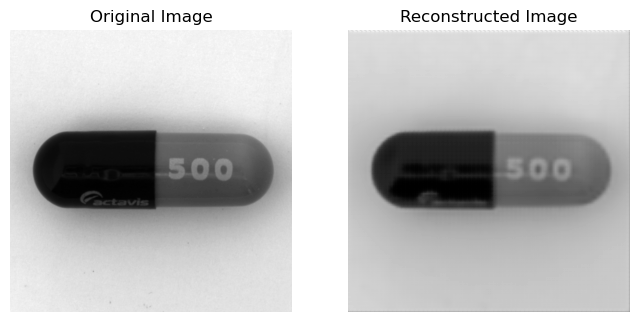

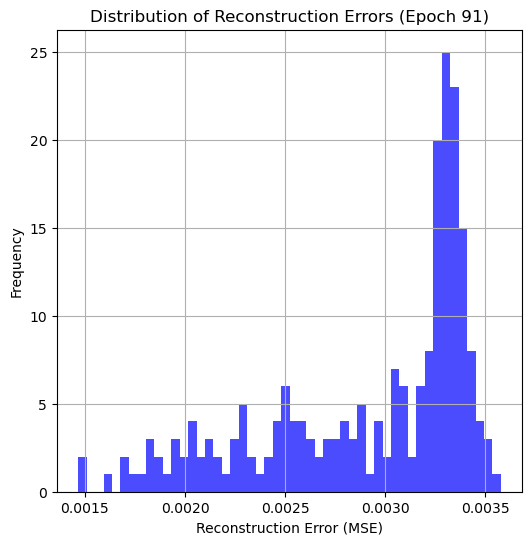

Epoch [92/100], Loss: 0.001624
Epoch [93/100], Loss: 0.001599
Model saved with test loss: 0.0016
Epoch [94/100], Loss: 0.001687
Epoch [95/100], Loss: 0.001600
Epoch [96/100], Loss: 0.001539
Model saved with test loss: 0.0015
Epoch [97/100], Loss: 0.001838
Epoch [98/100], Loss: 0.001720
Epoch [99/100], Loss: 0.001887
Epoch [100/100], Loss: 0.001620


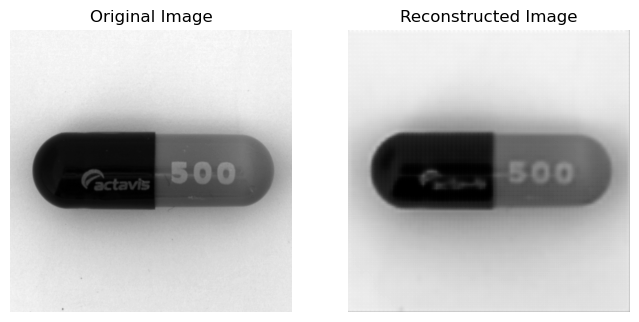

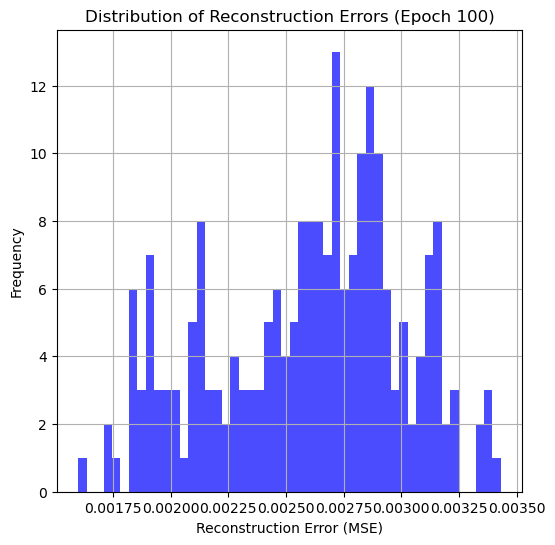

76 132
9 23
Test Accuracy: 0.5758
False Positive Rate: 0.3913


In [21]:
# Will use the images in the "train/good" directory to establish a baseline of features for defect-free images.
categories = ["capsule", "screw", "cable", "transistor"]

# Iterate through the directories of images
for item in categories:
    item_path = os.path.join(base_dir, item)
    train_path = os.path.join(item_path, 'train')
    test_path = os.path.join(item_path, 'test')
    ground_truth_path = os.path.join(item_path, 'ground_truth')

    print(f"Processing: {item}")
    # Create the dataset and DataLoader    
    train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    model = Autoencoder()
    # Initialize loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    epochs = 100
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trained_autoencoder, reconstruction_errors = train_autoencoder(model, train_loader, item, epochs, device)    

    reconstruction_errors_array = np.array(reconstruction_errors)

    threshold = np.median(reconstruction_errors_array) # Threshold for anomaly detection
    test_dataset = TestDataset(root_dir=test_path, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    test_autoencoder(trained_autoencoder, test_loader, device, threshold)
    break